# Reanalyzing Dandiset #000458

This notebook works through some basic reanalysis of Dandiset #000458 to demonstrate how easy and straightforward the process is!

We will aim to make an approximate reproduction of Figure 4B from the 2023 _Neuron_ article [“Active cortical networks promote shunting fast synaptic inhibition _in vivo_”](https://doi.org/10.1016/j.neuron.2023.08.005) by Burman et al.

In [1]:
from pynwb import NWBHDF5IO
from fsspec import filesystem
from h5py import File
from dandi.dandiapi import DandiAPIClient
import numpy as np
import matplotlib.pyplot as plt

def stream_nwbfile(DANDISET_ID, file_path):
    '''Stream NWB file from DANDI archive.
    
    Parameters
    ----------
    DANDISET_ID : str
        Dandiset ID
    file_path : str
        Path to NWB file in DANDI archive
    
    Returns
    -------
    nwbfile : NWBFile
        NWB file
    io : NWBHDF5IO
        NWB IO object (for closing)
        
    Notes
    -----
    The io object must be closed after use.
    '''
    with DandiAPIClient() as client:
        asset = client.get_dandiset(DANDISET_ID, 'draft').get_asset_by_path(file_path)
        s3_url = asset.get_content_url(follow_redirects=1, strip_query=True)
    fs = filesystem("http")
    file_system = fs.open(s3_url, "rb")
    file = File(file_system, mode="r")
    io = NWBHDF5IO(file=file, load_namespaces=True)
    nwbfile = io.read()
    return nwbfile, io

First we'll stream in the NWB file directly from DANDI using the function defined above.

In [2]:
DANDISET_ID = "000458"
file_path = "sub-586468/sub-586468_ses-20210819_behavior+ecephys.nwb"
nwbfile, io = stream_nwbfile(DANDISET_ID, file_path)
display(nwbfile)

/opt/anaconda3/envs/blog_000458_env/lib/python3.12/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.1 because version 1.8.0 is already loaded.
  return func(args[0], **pargs)
/opt/anaconda3/envs/blog_000458_env/lib/python3.12/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.5.0 because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
/opt/anaconda3/envs/blog_000458_env/lib/python3.12/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.2.0 because version 0.5.0 is already loaded.
  return func(args[0], **pargs)


,location,group,group_name,is_data_valid,probe_vertical_position,probe_horizontal_position,x,y,z,reference
id,,,,,,,,,,
0,VISl,"EEG array pynwb.ecephys.ElectrodeGroup at 0x5116662832\nFields:\n description: 30-ch surface grid\n device: EEG array pynwb.device.Device at 0x5107244336\nFields:\n description: H32 Mouse EEG (30-ch)\n manufacturer: Neuronexus\n\n location: skull surface, both hemispheres\n",EEG array,True,-1,-1,377.0,58.0,82.0,"stainless steel skull screw, left CB"
1,VISp,"EEG array pynwb.ecephys.ElectrodeGroup at 0x5116662832\nFields:\n description: 30-ch surface grid\n device: EEG array pynwb.device.Device at 0x5107244336\nFields:\n description: H32 Mouse EEG (30-ch)\n manufacturer: Neuronexus\n\n location: skull surface, both hemispheres\n",EEG array,True,-1,-1,377.0,24.0,141.0,"stainless steel skull screw, left CB"
2,RSPagl,"EEG array pynwb.ecephys.ElectrodeGroup at 0x5116662832\nFields:\n description: 30-ch surface grid\n device: EEG array pynwb.device.Device at 0x5107244336\nFields:\n description: H32 Mouse EEG (30-ch)\n manufacturer: Neuronexus\n\n location: skull surface, both hemispheres\n",EEG array,True,-1,-1,377.0,20.0,188.0,"stainless steel skull screw, left CB"
3,VISal,"EEG array pynwb.ecephys.ElectrodeGroup at 0x5116662832\nFields:\n description: 30-ch surface grid\n device: EEG array pynwb.device.Device at 0x5107244336\nFields:\n description: H32 Mouse EEG (30-ch)\n manufacturer: Neuronexus\n\n location: skull surface, both hemispheres\n",EEG array,True,-1,-1,333.0,47.0,79.0,"stainless steel skull screw, left CB"
,location,group,group_name,is_data_valid,probe_vertical_position,probe_horizontal_position,x,y,z,reference
id,,,,,,,,,,
0,VISl,"EEG array pynwb.ecephys.ElectrodeGroup at 0x5116662832\nFields:\n description: 30-ch surface grid\n device: EEG array pynwb.device.Device at 0x5107244336\nFields:\n description: H32 Mouse EEG (30-ch)\n manufacturer: Neuronexus\n\n location: skull surface, both hemispheres\n",EEG array,True,-1,-1,377.0,58.0,82.0,"stainless steel skull screw, left CB"
1,VISp,"EEG array pynwb.ecephys.ElectrodeGroup at 0x5116662832\nFields:\n description: 30-ch surface grid\n device: EEG array pynwb.device.Device at 0x5107244336\nFields:\n description: H32 Mouse EEG (30-ch)\n manufacturer: Neuronexus\n\n location: skull surface, both hemispheres\n",EEG array,True,-1,-1,377.0,24.0,141.0,"stainless steel skull screw, left CB"
2,RSPagl,"EEG array pynwb.ecephys.ElectrodeGroup at 0x5116662832\nFields:\n description: 30-ch surface grid\n device: EEG array pynwb.device.Device at 0x5107244336\nFields:\n description: H32 Mouse EEG (30-ch)\n manufacturer: Neuronexus\n\n location: skull surface, both hemispheres\n",EEG array,True,-1,-1,377.0,20.0,188.0,"stainless steel skull screw, left CB"


From the nwbfile html render, we can see that
- the epochs table has the isoflurane timing information
- the trials table has the stimulation times and associated properties
- the units table has spike-sorted units, each with a list of spike times

We'll need to select stimulation times from the awake and anesthetized period separately in order to make a comparison. To avoid any edge effects, we will omit 100s before and after isoflurane induction.

In [4]:
epochs_df = nwbfile.epochs.to_dataframe()
display(epochs_df)

iso_start_time = epochs_df["start_time"].iloc[-1] + 100
iso_stop_time = epochs_df["stop_time"].iloc[-1] - 100
awake_start_time = 100
awake_stop_time = epochs_df["start_time"].iloc[0] - 100

print(f"Awake Period (omitting edge effects): {awake_start_time}s-{awake_stop_time}s")
print(f"Isoflurane Period (omitting edge effects): {iso_start_time}s-{iso_stop_time}s")

,start_time,stop_time,tags
id,,,
0,4219.153339,4345.123339,[isoflurane_induction]
1,4345.133339,8598.253339,[isoflurane_anesthesia]


Awake Period (omitting edge effects): 100s-4119.153338945424s
Isoflurane Period (omitting edge effects): 4445.133338945424s-8498.253338945426s


Now we will select 3 representative trials from each time period.

In [6]:
trials_df = nwbfile.trials.to_dataframe()

iso_trials = trials_df[
    (trials_df['is_running'] == False) &
    (trials_df['is_valid'] == True) &
    (trials_df['behavioral_epoch'] == 'isoflurane') &
    (trials_df['start_time'].values >= iso_start_time) &
    (trials_df['start_time'].values <= iso_stop_time)
]
awake_trials = trials_df[
    (trials_df['is_running'] == False) &
    (trials_df['is_valid'] == True) &
    (trials_df['behavioral_epoch'] == 'awake') &
    (trials_df['start_time'].values >= awake_start_time) &
    (trials_df['start_time'].values <= awake_stop_time)
]

rng = np.random.default_rng(1723217369) # int(datetime.now().timestamp()) at the time of writing
representative_iso_trials = iso_trials.sample(n=3, random_state=rng)
iso_stim_times = representative_iso_trials['start_time'].values
representative_awake_trials = awake_trials.sample(n=3, random_state=rng)
awake_stim_times = representative_awake_trials['start_time'].values

print("Representative Awake Trials")
display(representative_awake_trials)
print("Representative Isoflurane Trials")
display(representative_iso_trials)

Representative Awake Trials


,start_time,stop_time,stimulus_type,stimulus_description,estim_current,estim_target_region,estim_target_depth,behavioral_epoch,is_running,is_valid
id,,,,,,,,,,
762,3645.52518,3645.52558,electrical,biphasic,25,SSp,deep,awake,False,True
522,2680.13009,2680.13049,electrical,biphasic,25,SSp,deep,awake,False,True
575,2891.89533,2891.89573,electrical,biphasic,25,SSp,deep,awake,False,True


Representative Isoflurane Trials


,start_time,stop_time,stimulus_type,stimulus_description,estim_current,estim_target_region,estim_target_depth,behavioral_epoch,is_running,is_valid
id,,,,,,,,,,
1051,5826.67787,5826.67827,electrical,biphasic,45,SSp,deep,isoflurane,False,True
907,5249.74729,5249.74769,electrical,biphasic,45,SSp,deep,isoflurane,False,True
1144,6201.42846,6201.42886,electrical,biphasic,45,SSp,deep,isoflurane,False,True


To match Figure 4B, we will look specifically at primary somatosensory neurons (SSp).

In [7]:
ssp_mask = np.isin(nwbfile.units.get('location').data[:], ['SSp-bfd', 'SSp-ll', 'SSp-tr'])
ssp_indices = np.where(ssp_mask)[0]
print("Number of SSp Units", len(ssp_indices))
ssp_units = nwbfile.units.get(ssp_indices)

Number of SSp Units 57


Finally, we will plot the spike times of all of the SSp units for each representative stimulation time (awake and anesthetized).

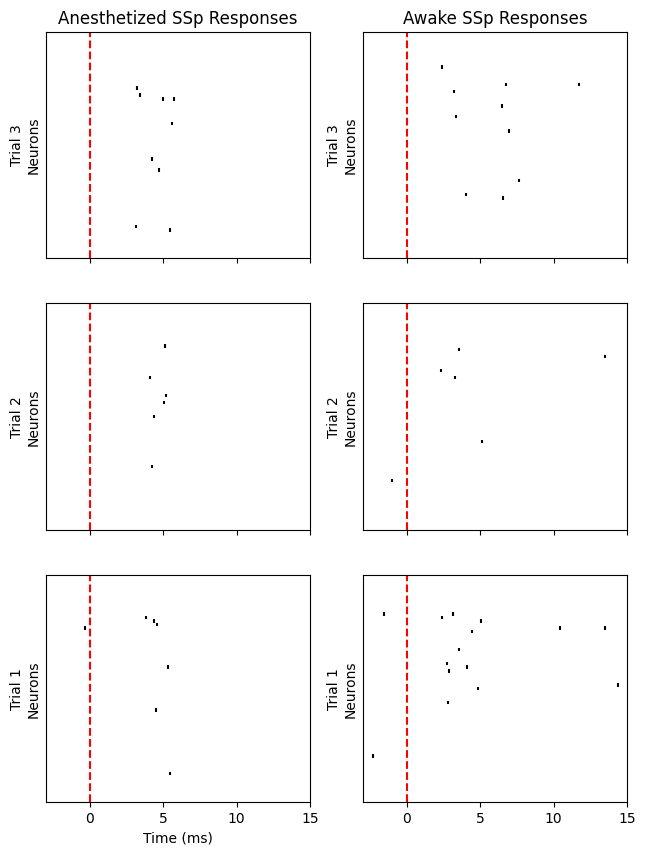

In [8]:
pre_duration = 3e-3
post_duration = 15e-3

trial_names = ['Trial 3', 'Trial 2', 'Trial 1']
fig, axs = plt.subplots(3, 2, figsize=(7.5, 10), sharex=True, sharey=True)
for j, stim_time in enumerate(iso_stim_times):
    ax = axs[j, 0]
    trial_name = trial_names[j]
    all_spike_times = []
    for i in range(len(ssp_units)):
        spike_times = ssp_units.iloc[i].spike_times
        spike_times = spike_times[(spike_times > stim_time - pre_duration) & (spike_times < (stim_time + post_duration))]
        spike_times = (spike_times - stim_time) * 1e3
        all_spike_times.append(spike_times)

    ax.eventplot(all_spike_times, colors='k')
    ax.axvline(0, color='r', linestyle='--')
    ax.set_xlim(-pre_duration * 1e3, post_duration * 1e3)
    ax.set_yticks([])
    ax.set_ylabel(trial_name+'\nNeurons')
axs[-1, 0].set_xlabel('Time (ms)')
_ = axs[0, 0].set_title('Anesthetized SSp Responses')

for j, stim_time in enumerate(awake_stim_times):
    ax = axs[j, 1]
    trial_name = trial_names[j]
    all_spike_times = []
    for i in range(len(ssp_units)):
        spike_times = ssp_units.iloc[i].spike_times
        spike_times = spike_times[(spike_times > stim_time - pre_duration) & (spike_times < (stim_time + post_duration))]
        spike_times = (spike_times - stim_time) * 1e3
        all_spike_times.append(spike_times)

    ax.eventplot(all_spike_times, colors='k')
    ax.axvline(0, color='r', linestyle='--')
    ax.set_xlim(-pre_duration * 1e3, post_duration * 1e3)
    ax.set_yticks([])
    ax.set_ylabel(trial_name+'\nNeurons')
axs[-1, 0].set_xlabel('Time (ms)')
_ = axs[0, 1].set_title('Awake SSp Responses')

As in Figure 4B of the paper, the raster plots show that the awake responses are more distributed in time (less synchronous) than the anesthetized responses.